# Environment

## Imports

In [11]:
import scanpy as sc
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import IterableDataset, DataLoader, get_worker_info
from collections import defaultdict

sns.set_theme(style="white")

## Helping functions

## Load data

In [3]:
adata = sc.read_h5ad("data/pbmc10k_atac_filtered.h5ad")
adata

AnnData object with n_obs × n_vars = 10006 × 260822
    obs: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'celltype', 'n_features_per_cell', 'total_fragment_counts'
    var: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'binary'

# Preprocessing

## Build a negative sampling and subsampling distributions

Let's visualise the subsampling probabilities

Text(0, 0.5, 'Keep probability')

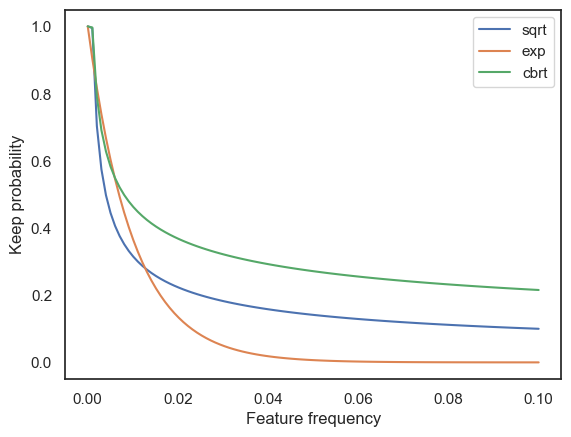

In [4]:
t = 1e-3
p = np.linspace(0, 0.1, 100)
keep_probability1 = np.minimum(1.0, np.sqrt(t / np.maximum(p, 1e-12)))
keep_probability2 = np.minimum(1.0, np.exp( np.maximum(p, 1e-12) / -t * 1e-1 ))
keep_probability3 = np.minimum(1.0, np.cbrt(t / np.maximum(p, 1e-12)))

plt.plot(p, keep_probability1, label=f"sqrt")
plt.plot(p, keep_probability2, label="exp")
plt.plot(p, keep_probability3, label="cbrt")
plt.legend()
plt.xlabel("Feature frequency")
plt.ylabel("Keep probability")

In [5]:
# Negative sampling distribution
frequency = adata.var.cisTopic_nr_acc / adata.var.cisTopic_nr_acc.sum()
neg_probability = np.power(np.maximum(frequency, 1e-12), 0.75)
neg_probability = neg_probability / neg_probability.sum()

# Subsampling distribution
t = 5e-7
keep_probability = np.minimum(1.0, np.sqrt(t / np.maximum(frequency, 1e-12)))

# Add those to adata.var
adata.var["neg"] = neg_probability
adata.var["keep"] = keep_probability
adata.var["frequency"] = frequency

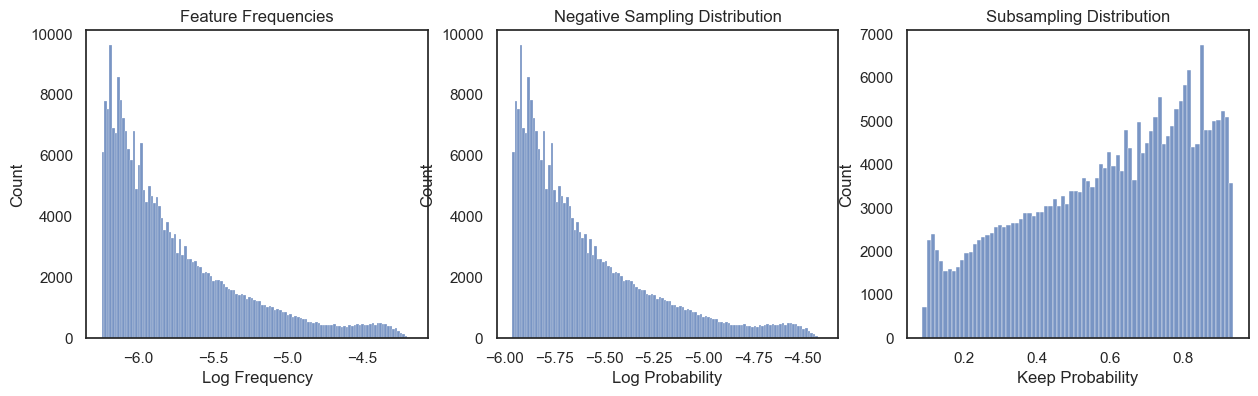

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(np.log10(frequency), ax=ax1)
ax1.set_xlabel("Log Frequency")
ax1.set_title("Feature Frequencies")

sns.histplot(np.log10(neg_probability), ax=ax2)
ax2.set_xlabel("Log Probability")
ax2.set_title("Negative Sampling Distribution")

sns.histplot(keep_probability, ax=ax3)
ax3.set_xlabel("Keep Probability")
ax3.set_title("Subsampling Distribution")
plt.show()

<Axes: xlabel='neg', ylabel='Chromosome'>

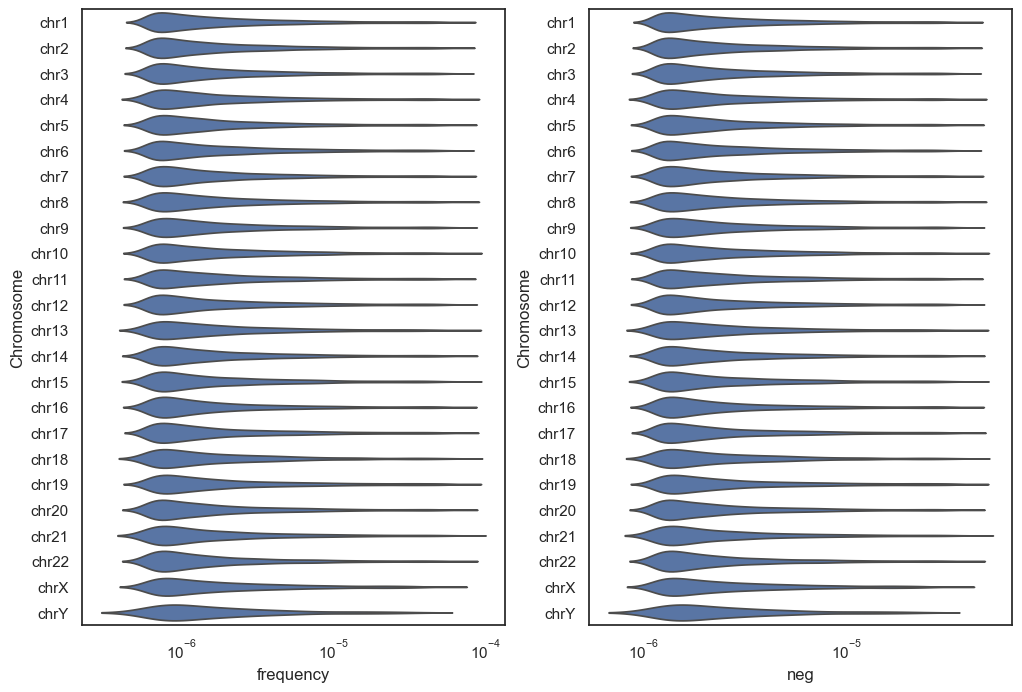

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
sns.violinplot(data=adata.var, x="frequency", y="Chromosome", log_scale=10, ax=ax1, inner=None)
sns.violinplot(data=adata.var, x="neg", y="Chromosome", log_scale=10, ax=ax2, inner=None)

<Axes: xlabel='proportion', ylabel='Chromosome'>

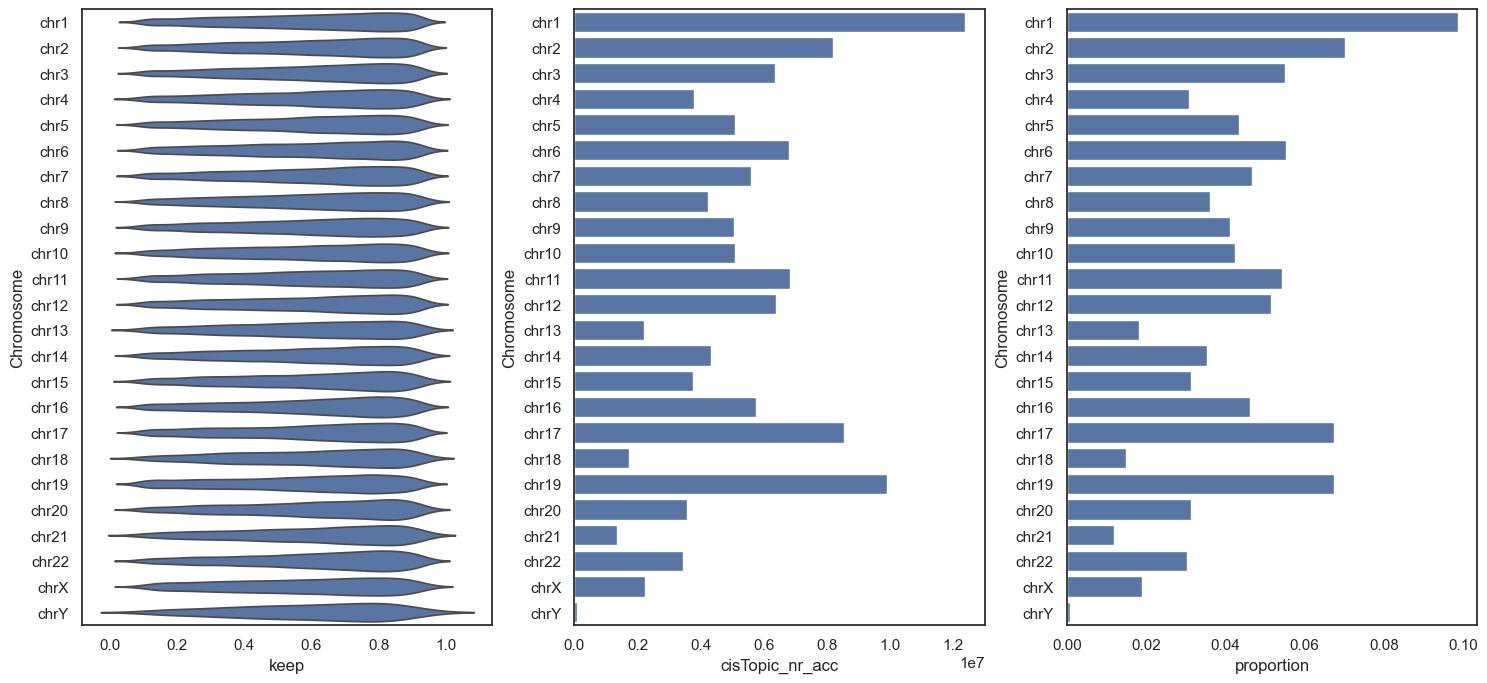

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))


sns.violinplot(data=adata.var, x="keep", y="Chromosome", ax=ax1, inner=None)
sns.barplot(data=adata.var, x="cisTopic_nr_acc", y="Chromosome", errorbar=None, estimator="sum", ax=ax2)
sns.countplot(data=adata.var, y="Chromosome", stat="proportion", ax=ax3)

## Dataset



In [ ]:
import torch.nn as nn

Text(0, 0.5, 'Weight for cis-pair sampling')

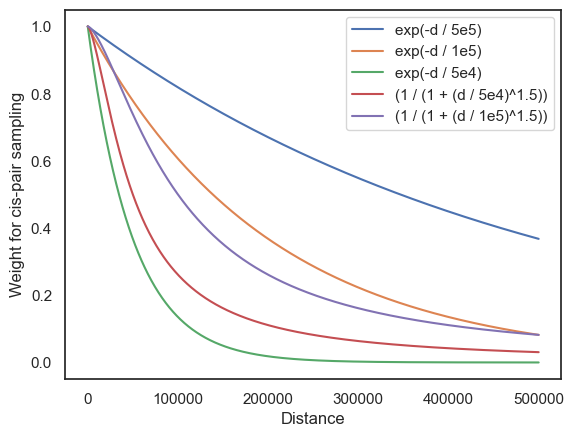

In [9]:
distance = np.linspace(0, 5e5, 1000)

plt.plot(distance, np.exp(-distance / 5e5), label=f"exp(-d / 5e5)")
plt.plot(distance, np.exp(-distance / 2e5), label="exp(-d / 1e5)")
plt.plot(distance, np.exp(-distance / 5e4), label="exp(-d / 5e4)")
plt.plot(distance, 1 / (1 + (distance / 5e4) ** 1.5), label="(1 / (1 + (d / 5e4)^1.5))")
plt.plot(distance, 1 / (1 + (distance / 1e5) ** 1.5), label="(1 / (1 + (d / 1e5)^1.5))")
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Weight for cis-pair sampling")

In [111]:
class PeakDataset(IterableDataset):
    def __init__(
            self,
            X,
            chrs,
            centers,
            neg_distribution,
            keep_distribution,
            samples_per_epoch=10000,
            n_pairs=10,
            n_negative=20,
            seed=4,
            trans_fraction=0.2,
            cis_window=500000,
            same_chr_negative_prob=0.5
        ):
        self.samples_per_epoch = samples_per_epoch
        self.n_pairs = n_pairs
        self.n_negative = n_negative
        self.seed = seed
        self.trans_fraction = trans_fraction
        self.cis_window = cis_window
        self.same_chr_negative_prob = same_chr_negative_prob

        self.X = X
        self.n_cells, self.n_peaks = self.X.shape
        self.chr = chrs
        self.centers = centers

        # Negative sampling distribution
        self.neg_distribution = torch.from_numpy(neg_distribution)
        self.neg_cat_all = torch.distributions.categorical.Categorical(probs=self.neg_distribution)

        self.by_chr = dict()
        self.neg_cat_chr = dict()
        for u in np.unique(self.chr):
            idxs = np.where(self.chr == u)[0]
            self.by_chr[u] = idxs
            self.neg_cat_chr[u] = torch.distributions.categorical.Categorical(
                probs=torch.from_numpy(neg_distribution[idxs] / (neg_distribution[idxs].sum() + 1e-12)).float()
            )

        # Subsampling distribution
        self.keep_distribution = keep_distribution

        # Counter
        self.counter = defaultdict(int)

    def _open_cell_peaks(self, cell_idx, rng):
        row = self.X.getrow(cell_idx)   # returns a 1×n sparse row (CSR-like)
        peaks = row.indices
        if peaks.size < 2:
            return peaks
        #print(cell_idx)
        #print(self.chr[peaks].value_counts())
        mask = rng.random(peaks.size) < self.keep_distribution[peaks]
        peaks = peaks[mask] if mask.any() else peaks
        return peaks
    
    def _sample_pair(self, peak_idx, open_peaks, rng):
        chr = self.chr[peak_idx]
        c_mid = self.centers[peak_idx]

        if rng.random() > self.trans_fraction:
            candidates = open_peaks[(self.chr[open_peaks] == chr) & (open_peaks != peak_idx)]
            if candidates.size > 0:
                distances = np.abs(self.centers[candidates] - c_mid)
                in_cis_window = distances <= self.cis_window
                if in_cis_window.any():
                    weights = np.exp(-distances[in_cis_window] / self.cis_window)
                    weights = weights / (weights.sum() + 1e-12)
                    return int(rng.choice(candidates[in_cis_window], p=weights))


        paired_peaks = open_peaks[open_peaks != peak_idx]
        return int(rng.choice(paired_peaks)) if paired_peaks.size > 0 else None
    
    def _sample_negatives(self, peak_idx, pair_idx, rng):
        if rng.random() < self.same_chr_negative_prob:
            chr = self.chr[peak_idx]
            idxs = self.by_chr[chr]
            draws = self.neg_cat_chr[chr].sample((self.n_negative,))
            negatives = torch.from_numpy(idxs[draws.numpy().astype(int)])
        else:
            negatives = self.neg_cat_all.sample((self.n_negative,))

        if isinstance(negatives, torch.Tensor):
            negatives = torch.where(negatives == peak_idx, (negatives + 1) % self.n_peaks, negatives)
            negatives = torch.where(negatives == pair_idx, (negatives + 2) % self.n_peaks, negatives)
        return negatives

    def __iter__(self):
        wi = get_worker_info()
        worker_id = wi.id if wi else 0
        rng = np.random.Generator(np.random.PCG64(self.seed + 1337 * (worker_id + 1)))

        produced = 0
        while produced < self.samples_per_epoch:
            cell_idx = rng.integers(0, self.n_cells)
            open_peaks = self._open_cell_peaks(cell_idx, rng)
            #print(f"Cell {cell_idx} has {open_peaks.size} open peaks.")
            values, counts = np.unique(self.chr[open_peaks], return_counts=True)
            # Creates a dictionary
            count_dict = dict(zip(values, counts))
            #print(f"Open peaks by chromosome: {count_dict}")
            if open_peaks.size < 2:
                continue

            sampled_peaks = rng.choice(open_peaks, size=self.n_pairs, replace=(len(open_peaks) < self.n_pairs))
            #print(self.chr[sampled_peaks].to_list())
            for peak_idx in sampled_peaks:
                #print(self.chr[peak_idx])
                pair_idx = self._sample_pair(peak_idx, open_peaks, rng)
                if pair_idx is None:
                    continue

                negatives = self._sample_negatives(peak_idx, pair_idx, rng)
                self.counter[self.chr[peak_idx]] += 1
                yield int(peak_idx), int(pair_idx), negatives

                produced += 1
                if produced >= self.samples_per_epoch:
                    break

## DataLoader

In [112]:
def peak2vec_collate(batch):
    peaks, peak_pairs, negatives = zip(*batch)
    peaks = torch.tensor(peaks, dtype=torch.long)
    peak_pairs = torch.tensor(peak_pairs, dtype=torch.long)
    negatives = torch.stack(negatives, dim=0).long()
    return peaks, peak_pairs, negatives

In [113]:
centers = ((adata.var["Start"].values + adata.var["End"].values) // 2).astype(np.int64)
neg_distribution = adata.var["neg"].values
keep_distribution = adata.var["keep"].values


dataset1 = PeakDataset(adata.X, adata.var["Chromosome"].values, centers, neg_distribution, keep_distribution, samples_per_epoch=20000, n_pairs=20, n_negative=15, seed=4, trans_fraction=0.2, cis_window=500000, same_chr_negative_prob=0.5)
loader1 = DataLoader(dataset1, batch_size=512, collate_fn=peak2vec_collate, num_workers=0, pin_memory=True)

In [114]:
iterator = iter(loader1)

In [115]:
peaks, peak_pairs, negatives = next(iterator)
peaks.size(), peak_pairs.size(), negatives.size(), dataset1.counter, peaks, peak_pairs

(torch.Size([512]),
 torch.Size([512]),
 torch.Size([512, 15]),
 defaultdict(int,
             {'chr12': 33,
              'chr2': 34,
              'chr14': 13,
              'chr5': 26,
              'chr17': 29,
              'chr1': 57,
              'chr4': 19,
              'chr3': 26,
              'chr19': 33,
              'chr22': 13,
              'chr15': 19,
              'chr16': 23,
              'chr6': 30,
              'chr20': 14,
              'chr21': 5,
              'chr8': 20,
              'chr10': 25,
              'chr7': 23,
              'chr18': 7,
              'chr9': 16,
              'chr11': 31,
              'chrX': 8,
              'chr13': 8}),
 tensor([149924,  32081, 175140, 171167,  70571, 214384,  23088,  63302,  50588,
         223839, 252715, 184930, 198226, 204311, 190179,  70058, 228325,  83995,
         227019,  73176, 180317,  55917, 156597, 243569,  75836,  50368, 239706,
         246275, 112142, 131168,  75302, 180224,  43259, 103287, 1